# MS5001 Group Project

#### **Done by:**
TANG WEN YUE; e0920872@u.nus.edu  
ZHANG SHUANG; e1582514@u.nus.edu  
GAN LEA WAH IVOR; e1538123@u.nus.edu  
GAN ZHENG WEI, TIMOTHY; e1561523@u.nus.edu  

#### **Chosen dataset:**
Airline Sentiments

USE PYTHON 3.12!!!!

This section imports all the required libraries. For convenience and organisation, the libraries are imported at the top section of this notebook.

Note: Requires Jupyter Extension 2025.8.0 in VS Code due to a bug of Python 3.14 running in virtual environments.
https://github.com/microsoft/vscode-jupyter/issues/17042

In [6]:
#Import libraries
import pandas as pd
import re
import emoji

## Section 1: Data Exploration

In this step, we import the data into a pandas dataframe and perform some exploratory data analysis to get a brief initial look at the dataset.

In [7]:
#Import data into a pandas dataframe
tweet_data = pd.read_csv("Airline Sentiment/Tweets.csv")
display(tweet_data.head(10))
print(f"Number of rows {tweet_data.shape[0]}")

,airline_sentiment,sentiment_confidence,text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.
1,positive,0.3486,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...
5,negative,1.0000,@VirginAmerica seriously would pay $30 a fligh...
6,positive,0.6745,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,0.6340,@VirginAmerica Really missed a prime opportuni...
8,positive,0.6559,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,1.0000,"@VirginAmerica it was amazing, and arrived an ..."


Number of rows 14639


In [9]:
#wrap text so we can see the entire tweet better

# Apply CSS styling for text wrapping for the first 30 rows
styled_df = tweet_data.head(5).style.set_properties(
    **{
        'inline-size': '200px',  # Set a fixed width for the column
        'overflow-wrap': 'break-word',
        'white-space': 'normal'
    },
    subset=['text']
)

# Display the styled DataFrame (will render as HTML in compatible environments)
styled_df

,airline_sentiment,sentiment_confidence,text
0,neutral,1.000000,@VirginAmerica What @dhepburn said.
1,positive,0.348600,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,0.683700,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,1.000000,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,1.000000,@VirginAmerica and it's a really big bad thing about it


From the data exploration we can see that the tweets are mostly text-based, with certain structural elements such as handles (@XXX) and tags (#XXX). Additional features we might need to consider are emojis and how to encode them. URLs (http:XXX) in the text are also a elements of the tweet that do not add any additional value and need to be removed.

## Step 2: Data Cleaning

From the exploratory data analysis, we recognise that there is a need to clean the tweet data.
To do so, we will:
1. Standardise the text to lowercase so that the same words can be encoded in the same way regardless if they are uppercase or lowercase
2. Convert emojis into textual form so that they can be encoded
3. The cleaned text is stored in a new column "cleaned_text"

In [10]:
#Clean tweet data

#Standardise the tweets by setting all text to lowercase
tweet_data["cleaned_text"]=tweet_data["text"].str.lower()

In [11]:
#Remove URLs from the tweets

#This regex pattern matches URLs starting with http, https, or www.
tweet_data["cleaned_text"]=tweet_data["cleaned_text"].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

The emoji encoding method is taken from:
https://medium.com/@ebimsv/nlp-series-day-5-handling-emojis-strategies-and-code-implementation-0f8e77e3a25c

In [12]:
#convert emojis to text so that vector text encoding can pick up the sentiment

def emoji_to_text(text):
    return emoji.demojize(text)

tweet_data["cleaned_text"]=tweet_data["cleaned_text"].apply(emoji_to_text)

In [13]:
#inspect the cleaned text


# Apply CSS styling for text wrapping for rows with index 23 and 29, since these have emojis
styled_df = tweet_data.iloc[[23,29]].style.set_properties(
    **{
        'inline-size': '200px',  # Set a fixed width for the column
        'overflow-wrap': 'break-word',
        'white-space': 'normal'
    },
    subset=['cleaned_text']
)

# Display the styled DataFrame (will render as HTML in compatible environments)
styled_df

,airline_sentiment,sentiment_confidence,text,cleaned_text
23,negative,1.000000,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,@virginamerica you guys messed up my seating.. i reserved seating with my friends and you guys gave my seat away ... :enraged_face: i want free internet
29,negative,1.000000,"@VirginAmerica hi! I just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during Flight Booking Problems 😢","@virginamerica hi! i just bked a cool birthday trip with you, but i can't add my elevate no. cause i entered my middle name during flight booking problems :crying_face:"


In [51]:
#


## Step 3: Feature Extraction

The following methods are used to convert the text into a vector representation for clustering:
1. Bag-of-Words model, which is a simple count of how often a word appears across a corpus of text. This is a simple method which ignores word ordering.
2. TD-IDF vectorization
3. Entity recognition?
4. Extract only sentiment-related words?

Bag of Words model taken from https://www.kaggle.com/code/vipulgandhi/bag-of-words-model-for-beginners

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

#Extract features
tweets=tweet_data["cleaned_text"].tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets)

#Inspect the vocabulary that was extracted, eg the unique words
vocabulary = vectorizer.get_feature_names_out()
print("Vocabulary:", sorted(vocabulary))

Vocabulary: ['00', '000', '000114', '000419', '000ft', '000lbs', '0011', '0016', '00a', '00am', '00p', '00pm', '01', '0162389030167', '0162424965446', '0162431184663', '0167560070877', '0185', '01pm', '02', '0200', '03', '0316', '0372389047497', '04', '0400', '05', '0510', '0530', '05am', '05pm', '06', '0600', '0638', '0671', '07', '0736', '0769', '07p', '08', '0985', '0_0', '0xjared', '10', '100', '1000', '1000cost', '1001', '1002', '1007', '1008', '101', '1016', '1019', '1020', '1024', '1025', '1027', '1028', '103', '1030pm', '1032', '1038', '104', '1041', '1046', '105', '1050', '1051', '1058', '106', '1065', '1071', '1074', '1079871763', '108', '1080', '1081', '1086', '108639', '1089', '1098', '1099', '10a', '10am', '10d', '10f', '10hrs', '10m', '10min', '10mins', '10p', '10pm', '10th', '10voucherwhatajoke', '10x', '10x9x17', '10yr', '11', '110', '1101', '1102', '1106', '1108', '1109', '1114', '1117', '1119', '112', '1120am', '1125', '1130', '1130pm', '1133', '1136', '1137', '1138',

Instead of vectorizing the entire text, we can also try to limit the text to only sentiment-related words. This is done using VADER, a pre-trained sentiment analysis library available within the nltk library.
https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e

In [15]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Get the VADER lexicon words to see which words are used to determine sentiment
analyzer = SentimentIntensityAnalyzer()
vader_lexicon_string=analyzer.lexicon_file
vader_lexicon_list=[]
for each_line in vader_lexicon_string.split('\n'):
    vader_lexicon_list.append(each_line.split('\t')[0])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhangshuang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
print(vader_lexicon_list[:20])

['$:', '%)', '%-)', '&-:', '&:', "( '}{' )", '(%', "('-:", "(':", '((-:', '(*', '(-%', '(-*', '(-:', '(-:0', '(-:<', '(-:o', '(-:O', '(-:{', '(-:|>*']


In [17]:
vader_lexicon = SentimentIntensityAnalyzer().lexicon 
sentiment_words = list(vader_lexicon.keys())
print(sentiment_words[:20])  # Print the first 20 sentiment words

['$:', '%)', '%-)', '&-:', '&:', "( '}{' )", '(%', "('-:", "(':", '((-:', '(*', '(-%', '(-*', '(-:', '(-:0', '(-:<', '(-:o', '(-:O', '(-:{', '(-:|>*']


In [18]:
# For each cleaned tweet, check if any of the words are in the VADER lexicon and output only those words
def extract_vader_words(text):
    words = text.split()
    vader_words = [word for word in words if word in vader_lexicon_list]
    return ' '.join(vader_words)

tweet_data["vader_words"]=tweet_data["cleaned_text"].apply(extract_vader_words)

#inspect the cleaned text with only VADER words
tweet_data.head(10)
#Inspect the vocabulary that was extracted, eg the unique words
vocabulary = vectorizer.get_feature_names_out()
print("Vocabulary:", sorted(vocabulary))

Vocabulary: ['00', '000', '000114', '000419', '000ft', '000lbs', '0011', '0016', '00a', '00am', '00p', '00pm', '01', '0162389030167', '0162424965446', '0162431184663', '0167560070877', '0185', '01pm', '02', '0200', '03', '0316', '0372389047497', '04', '0400', '05', '0510', '0530', '05am', '05pm', '06', '0600', '0638', '0671', '07', '0736', '0769', '07p', '08', '0985', '0_0', '0xjared', '10', '100', '1000', '1000cost', '1001', '1002', '1007', '1008', '101', '1016', '1019', '1020', '1024', '1025', '1027', '1028', '103', '1030pm', '1032', '1038', '104', '1041', '1046', '105', '1050', '1051', '1058', '106', '1065', '1071', '1074', '1079871763', '108', '1080', '1081', '1086', '108639', '1089', '1098', '1099', '10a', '10am', '10d', '10f', '10hrs', '10m', '10min', '10mins', '10p', '10pm', '10th', '10voucherwhatajoke', '10x', '10x9x17', '10yr', '11', '110', '1101', '1102', '1106', '1108', '1109', '1114', '1117', '1119', '112', '1120am', '1125', '1130', '1130pm', '1133', '1136', '1137', '1138',

In [19]:
#Extract features for the tweets with only VADER words
tweets_vader=tweet_data["vader_words"].tolist()
vectorizer = CountVectorizer()
X_vader = vectorizer.fit_transform(tweets_vader)

One other thing we can also try is instead of encoding the entire tweet, we extract different features of the tweet in order to encode them separately.  
-Handles  
-Hashtags  
-Emojis  
-VADER words
-Remaining text (remove stopwords, tokenize, lemmatize)  

In [20]:
#Ignore this for now

#Extract features

#Initilaise a new dataframe to hold the extracted features
extracted_features=pd.DataFrame()

#Extract the handles
extracted_features["handles"]=tweet_data['cleaned_text'].str.findall(r'@(\w+)')

#Extract hashtags
extracted_features['hashtags']=tweet_data['cleaned_text'].str.findall(r'#(\w+)')

#Extract emojis
# Function to extract emojis from a string
def extract_emojis(text):
    if isinstance(text, str):  # Ensure it's a string to avoid errors with non-string types like NaN
        emoji_list = emoji.distinct_emoji_list(text)
        return emoji_list
    return '' # Return empty string for non-string values or if no emojis are found

# Apply the function to the 'text' column to create a new 'emojis' column
# Use text column instead of "cleaned_text" as the cleaned text has the emojis converted to text
extracted_features['emojis'] = tweet_data['text'].apply(extract_emojis)

#Extract sentiment-laden words using VADER lexicon
# For each cleaned tweet, check if any of the words are in the VADER lexicon and output only those words
def extract_vader_words_list(text):
    words = text.split()
    vader_words = [word for word in words if word in vader_lexicon_list]
    return vader_words
extracted_features['vader_words']=tweet_data["cleaned_text"].apply(extract_vader_words_list)

#Remove the extracted features from the cleaned text to get the remaining text
def remove_extracted_features(text, handles, hashtags, emojis, vader_words):
    # Remove handles
    for handle in handles:
        text = re.sub(r'@' + re.escape(handle), '', text)
    # Remove hashtags
    for hashtag in hashtags:
        text = re.sub(r'#' + re.escape(hashtag), '', text)
    # Remove emojis (convert emoji names back to actual emojis for removal)
    for emoji_name in emojis:
        emoji_char = emoji.emojize(emoji_name)
        text = text.replace(emoji_char, '')
    # Remove VADER words
    #Note: leave the VADER words in the remaining text for now as they are useful for the context of the tweet
    # for vader_word in vader_words:
    #     text = re.sub(r'\b' + re.escape(vader_word) + r'\b', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text
extracted_features['remaining_text'] = tweet_data.apply(
    lambda row: remove_extracted_features(
        row['cleaned_text'],
        extracted_features.at[row.name, 'handles'],
        extracted_features.at[row.name, 'hashtags'],
        extracted_features.at[row.name, 'emojis'],
        extracted_features.at[row.name, 'vader_words']
    ), axis=1
)

#
#named entity recognition?
#how to vectorise the rest of the text?



In [21]:
#Further clean the remaining text by removing stopwords, tokenizing, and lemmatizing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#Download necessary NLTK resources
nltk.download('stopwords')
#nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    
    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Lemmatizing is a more sophisticated form of stemming that considers the context and converts the word to its meaningful base form
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(lemmatized_tokens)
extracted_features['processed_remaining_text'] = extracted_features['remaining_text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhangshuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/zhangshuang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zhangshuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
#Ignore this for now

#Inspect the extracted features dataframe
extracted_features.head(10)

,handles,hashtags,emojis,vader_words,remaining_text,processed_remaining_text
0,"[virginamerica, dhepburn]",[],[],[],what said.,said
1,[virginamerica],[],[],[],plus you've added commercials to the experienc...,plus added commercial experience tacky
2,[virginamerica],[],[],[],i didn't today... must mean i need to take ano...,today must mean need take another trip
3,[virginamerica],[],[],"[aggressive, obnoxious]","it's really aggressive to blast obnoxious ""ent...",really aggressive blast obnoxious entertainmen...
4,[virginamerica],[],[],[bad],and it's a really big bad thing about it,really big bad thing
5,[virginamerica],[],[],"[seriously, pay, bad]",seriously would pay $30 a flight for seats tha...,seriously would pay flight seat playing really...
6,[virginamerica],[],[],[:)],"yes, nearly every time i fly vx this “ear worm...",yes nearly every time fly vx ear worm go away
7,[virginamerica],[],[],"[missed, opportunity]",really missed a prime opportunity for men with...,really missed prime opportunity men without ha...
8,[virginamerica],[],[],[:-d],"well, i didn't…but now i do! :-d",well
9,[virginamerica],[],[],[good],"it was amazing, and arrived an hour early. you...",amazing arrived hour early good


Then, we need to vectorise the individual columns so that our clustering algorithm can work.

In [17]:
#Vectorise the different features separately

#Use BoW for handles and hashtags since they are entities (categorical variables)
#Use word2vec for emojis, VADER words, and the remaining text, since they have semantic meaning


#Use word2vec since it performs better than BoW and TF-IDF for sentiment analysis tasks
#https://www.kaggle.com/code/aashkatrivedi/feature-extraction-for-sentiment-analysis

#https://okan.cloud/posts/2022-05-02-text-vectorization-using-python-word2vec/

#word2vec only works in individual tokens, hence after tokenizing the text, average the vector of each token
#To get the vector representation of the entire tweet for clustering
# https://medium.com/data-science/how-to-compute-sentence-similarity-using-bert-and-word2vec-ab0663a5d64
# https://stackoverflow.com/questions/69485542/how-to-generate-sentence-vector-using-word2vec

#Error in installing gensim, hence using Spacy's word2vec implementation instead

In [23]:
import spacy
#need to download the en_core_web_lg model
#python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg") # Load a model with pre-trained vectors

#Example of getting the vector for a sentence
sentence=extracted_features["processed_remaining_text"].iloc[1]
doc = nlp(sentence)
print(f"An example sentence is: {sentence}\nConverted to vector: {doc.vector.shape}")

/Users/zhangshuang/Desktop/Vscode/python/Lecture/project/MSI5001/MSI5001/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


An example sentence is: plus added commercial experience tacky
Converted to vector: (300,)


In [28]:
#Process the entire column of processed_remaining_text to get the vectors for all tweets
#apply a spacy pipeline to process the text in batches for efficiency

extracted_features['tweet_vectors'] = [doc.vector for doc in nlp.pipe(extracted_features['processed_remaining_text'])]

#vectorise the vader_words column to extract the sentiment
#column "VADER_vectors" is in a list format
def vectorise_vader_words(vader_words):
    if not vader_words:  # Check if the list is empty
        return [0.0] * nlp.vocab.vectors_length  # Return a zero vector of appropriate length
    else:
        # Join the list of words into a single string for processing
        text = ' '.join(vader_words)
        doc = nlp(text)
        return doc.vector
#Apply the function to the 'vader_words' column
extracted_features['VADER_vectors'] = extracted_features['vader_words'].apply(vectorise_vader_words)

In [29]:
extracted_features.head(20)

,handles,hashtags,emojis,vader_words,remaining_text,processed_remaining_text,tweet_vectors,VADER_vectors
0,"[virginamerica, dhepburn]",[],[],[],what said.,said,"[-0.27903, 0.7704, -0.14395, -0.22742, 0.04295...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,[virginamerica],[],[],[],plus you've added commercials to the experienc...,plus added commercial experience tacky,"[-0.11100141, 0.099898204, 0.0058671995, -0.22...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,[virginamerica],[],[],[],i didn't today... must mean i need to take ano...,today must mean need take another trip,"[0.04313771, 0.06851414, -0.14503086, 0.057888...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,[virginamerica],[],[],"[aggressive, obnoxious]","it's really aggressive to blast obnoxious ""ent...",really aggressive blast obnoxious entertainmen...,"[-0.28718907, 0.1739571, -0.053161103, 0.01345...","[-0.810645, 0.09858, -0.44092, -0.100004345, 0..."
4,[virginamerica],[],[],[bad],and it's a really big bad thing about it,really big bad thing,"[-0.368795, 0.2713655, -0.24436724, -0.1562424...","[-0.73351, 0.41392, -0.4425, -0.29127, -0.0961..."
5,[virginamerica],[],[],"[seriously, pay, bad]",seriously would pay $30 a flight for seats tha...,seriously would pay flight seat playing really...,"[-0.12187009, 0.040808637, -0.13669582, -0.134...","[-0.58491665, 0.17690332, -0.25590667, -0.1976..."
6,[virginamerica],[],[],[:)],"yes, nearly every time i fly vx this “ear worm...",yes nearly every time fly vx ear worm go away,"[0.101499595, 0.1289744, -0.1055785, -0.038814...","[0.0078241, 0.18229, -0.28217, -0.11632, -0.48..."
7,[virginamerica],[],[],"[missed, opportunity]",really missed a prime opportunity for men with...,really missed prime opportunity men without ha...,"[-0.09995666, 0.12475849, -0.0239225, -0.01092...","[0.0766895, 0.40429997, -0.182025, 0.31141, 0...."
8,[virginamerica],[],[],[:-d],"well, i didn't…but now i do! :-d",well,"[-0.12486, 0.06918, -0.31364, -0.31354, 0.1438...","[0.004373, 0.16607, -0.145875, -0.075595, -0.2..."
9,[virginamerica],[],[],[good],"it was amazing, and arrived an hour early. you...",amazing arrived hour early good,"[-0.0184722, 0.37330598, 0.050914995, -0.03402...","[-0.42625, 0.4431, -0.34517, -0.1326, -0.05816..."


In [30]:
#Compare cosine similarity between two vectors to evaluate whether the vectorisation is working as expected
import numpy as np
def cosine_similarity(vector1, vector2):
    """
    Calculates the cosine similarity between two vectors.

    Args:
        vector1 (numpy.ndarray): The first vector.
        vector2 (numpy.ndarray): The second vector.

    Returns:
        float: The cosine similarity between the two vectors.
    """
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)

    if norm_vector1 == 0 or norm_vector2 == 0:
        return 0  # Handle cases where one or both vectors are zero vectors

    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

print(f"Cosine similarity (VADER vectors) between tweet {extracted_features['vader_words'].iloc[3]} and {extracted_features['vader_words'].iloc[5]}: {cosine_similarity(extracted_features['VADER_vectors'].iloc[3], extracted_features['VADER_vectors'].iloc[5])}")
print(f"Cosine similarity (VADER vectors) between tweet {extracted_features['vader_words'].iloc[4]} and {extracted_features['vader_words'].iloc[9]}: {cosine_similarity(extracted_features['VADER_vectors'].iloc[4], extracted_features['VADER_vectors'].iloc[9])}")
print(f"Cosine similarity (VADER vectors) between tweet {extracted_features['vader_words'].iloc[16]} and {extracted_features['vader_words'].iloc[9]}: {cosine_similarity(extracted_features['VADER_vectors'].iloc[16], extracted_features['VADER_vectors'].iloc[9])}")




Cosine similarity (VADER vectors) between tweet ['aggressive', 'obnoxious'] and ['seriously', 'pay', 'bad']: 0.48103150725364685
Cosine similarity (VADER vectors) between tweet ['bad'] and ['good']: 0.7355090379714966
Cosine similarity (VADER vectors) between tweet ['excited', 'great'] and ['good']: 0.7263852953910828


In [47]:
#In this section, apply the VADER sentiment analysis tool to extract features
#Use tweet data  tweet_data["cleaned_text"] column which converted the emojis into text

analyzer = SentimentIntensityAnalyzer()

#apply the sentiment analyzer to each tweet and store the results in a pandas dataframe
#Each row in the new dataframe corresponds to a key in the sentiment dictionary
#neg, neu, pos, compound

VADER_sentiments=pd.DataFrame()

VADER_sentiments = tweet_data["cleaned_text"].apply(analyzer.polarity_scores).apply(pd.Series)

VADER_sentiments.head(10)

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.000,1.000,0.000,0.0000
2,0.000,1.000,0.000,0.0000
3,0.246,0.754,0.000,-0.5984
4,0.321,0.679,0.000,-0.5829
5,0.256,0.670,0.074,-0.5945
6,0.000,0.678,0.322,0.6908
7,0.171,0.618,0.210,0.1458
8,0.329,0.440,0.231,-0.2249
9,0.000,0.642,0.358,0.7717


## Step 4: Clustering

Perform clustering based on features

In [19]:
#Perform clustering based on features

In [31]:
#Baseline: use k-means clustering on the bag-of-words representation of the tweets
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
kmeans.fit(X)
# Cluster labels assigned to each data point (0, 1, or 2 for 3 clusters)
labels = kmeans.labels_

In [32]:
clustering_results=pd.DataFrame()
clustering_results["labels"]=tweet_data["airline_sentiment"]
clustering_results["labels_confidence"]=tweet_data["sentiment_confidence"]
clustering_results["kmeans_labels"]=labels
clustering_results.head(10)

,labels,labels_confidence,kmeans_labels
0,neutral,1.0000,2
1,positive,0.3486,0
2,neutral,0.6837,1
3,negative,1.0000,1
4,negative,1.0000,2
5,negative,1.0000,0
6,positive,0.6745,2
7,neutral,0.6340,2
8,positive,0.6559,2
9,positive,1.0000,1


Since the clustering is unsupervised (without labels), we need a way to match the the sentiment (labels) to the labels generated by the k means algorithm.

This is because we want to see if the clusters generated by the k-means clustering algorithm matches the labels in the dataset.

Hence, for each label (positive/neutral/negative) we extract the statistical mode of the corresponding kmeans label (0/1/2). To improve the accuracy of this estimation, we extract only labels that have a high confidence (>90%). If the k-means clustering matches the sentiment, we should be able to see that each label is mapped to a different kmeans label.

In [22]:
pos_est=clustering_results["kmeans_labels"][(clustering_results["labels"]=="positive") & 
                                            (clustering_results["labels_confidence"]>0.9)].mode()
neu_est=clustering_results["kmeans_labels"][(clustering_results["labels"]=="neutral") & 
                                            (clustering_results["labels_confidence"]>0.9)].mode()
neg_est=clustering_results["kmeans_labels"][(clustering_results["labels"]=="negative") & 
                                            (clustering_results["labels_confidence"]>0.9)].mode()

print(f"Mode kmeans label for positive sentiment: {pos_est[0]}")
print(f"Mode kmeans label for neutral sentiment: {neu_est[0]}")
print(f"Mode kmeans label for negative sentiment: {neg_est[0]}")

#try to do more clusters

Mode kmeans label for positive sentiment: 2
Mode kmeans label for neutral sentiment: 2
Mode kmeans label for negative sentiment: 1


Here we see that positive and neutral sentiments are mapped to the same label. Hence, it does not seem that the bag of words model can adequately separate the three sentiments. What if our initial assumption that there are only 3 clusters is incorrect? As the bag of words model encodes much more information than just the sentiment, there might by multiple clusters. We use the elbow method to look at the optimal number of clusters in the dataset.

WCSSE (Inertia) for K=1: 254061.6285265386
WCSSE (Inertia) for K=2: 246917.65822344585
WCSSE (Inertia) for K=3: 243044.99718066253
WCSSE (Inertia) for K=4: 240565.34025866658
WCSSE (Inertia) for K=5: 237980.28652485312
WCSSE (Inertia) for K=6: 236179.2668396104
WCSSE (Inertia) for K=7: 235081.13383122877
WCSSE (Inertia) for K=8: 233331.50462461417
WCSSE (Inertia) for K=9: 233263.62346248043
WCSSE (Inertia) for K=10: 231807.4827844483
WCSSE (Inertia) for K=11: 230920.59762215597
WCSSE (Inertia) for K=12: 229510.66700614232
WCSSE (Inertia) for K=13: 229104.59117867702
WCSSE (Inertia) for K=14: 227633.40032783122
WCSSE (Inertia) for K=15: 228174.1945232654
WCSSE (Inertia) for K=16: 227332.9820873333
WCSSE (Inertia) for K=17: 226436.31458802987
WCSSE (Inertia) for K=18: 225834.91688483424
WCSSE (Inertia) for K=19: 224792.9678969481
WCSSE (Inertia) for K=20: 226406.9193636962


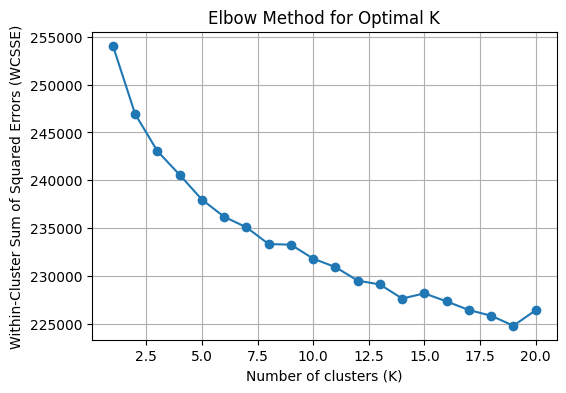

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Use Elbow Method to investigate whether there are more clusters
# Compute WCSSE for different values of K
wcsse = []
K_range = range(1, 21)
# runs Kmeans for k = 1 to 20
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    # X = vectorizer.fit_transform(tweets)  -> X is already defined earlier (sparse matrix) 
    kmeans.fit(X)
    wcsse.append(kmeans.inertia_)
    print(f"WCSSE (Inertia) for K={k}:", kmeans.inertia_)


# 3. Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcsse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Errors (WCSSE)')
plt.grid(True)
plt.show()

WCSSE (Inertia) for K=1: 18123.512671630626
WCSSE (Inertia) for K=2: 16751.582256188118
WCSSE (Inertia) for K=3: 16301.123439524961
WCSSE (Inertia) for K=4: 15277.756397950572
WCSSE (Inertia) for K=5: 14833.951771230675
WCSSE (Inertia) for K=6: 14835.491816105314
WCSSE (Inertia) for K=7: 14650.75600777183
WCSSE (Inertia) for K=8: 13943.820120722954
WCSSE (Inertia) for K=9: 13734.200456163051
WCSSE (Inertia) for K=10: 13865.752468764176
WCSSE (Inertia) for K=11: 13534.535074062518
WCSSE (Inertia) for K=12: 13097.738687077148
WCSSE (Inertia) for K=13: 13186.12400359098
WCSSE (Inertia) for K=14: 13184.98036001722
WCSSE (Inertia) for K=15: 12742.380842761848
WCSSE (Inertia) for K=16: 12538.530672802039
WCSSE (Inertia) for K=17: 12445.363607048706
WCSSE (Inertia) for K=18: 12266.39281789156
WCSSE (Inertia) for K=19: 12280.183483899955
WCSSE (Inertia) for K=20: 12289.210230767418


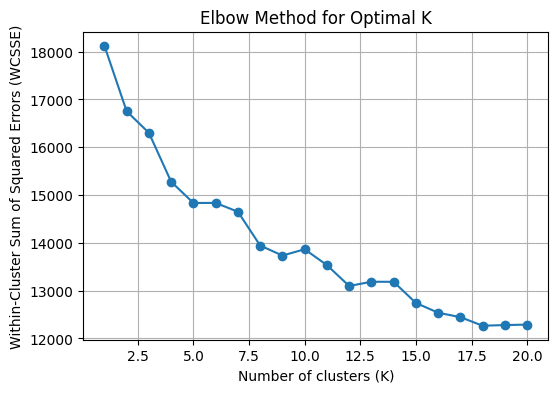

In [24]:
#Run the elbow method again but using only the VADER words

# Use Elbow Method to investigate whether there are more clusters
# Compute WCSSE for different values of K
wcsse = []
K_range = range(1, 21)
# runs Kmeans for k = 1 to 20
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_vader)
    wcsse.append(kmeans.inertia_)
    print(f"WCSSE (Inertia) for K={k}:", kmeans.inertia_)


# 3. Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcsse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Errors (WCSSE)')
plt.grid(True)
plt.show()

WCSSE (Inertia) for K=1: 86744.53125
WCSSE (Inertia) for K=2: 80808.28125
WCSSE (Inertia) for K=3: 76821.859375
WCSSE (Inertia) for K=4: 74198.84375
WCSSE (Inertia) for K=5: 72081.328125
WCSSE (Inertia) for K=6: 70793.03125
WCSSE (Inertia) for K=7: 69914.5078125
WCSSE (Inertia) for K=8: 69077.296875
WCSSE (Inertia) for K=9: 68371.6875
WCSSE (Inertia) for K=10: 67670.0625
WCSSE (Inertia) for K=11: 67030.3046875
WCSSE (Inertia) for K=12: 66454.1171875
WCSSE (Inertia) for K=13: 65963.53125
WCSSE (Inertia) for K=14: 65335.07421875
WCSSE (Inertia) for K=15: 64931.890625
WCSSE (Inertia) for K=16: 64413.81640625
WCSSE (Inertia) for K=17: 63996.32421875
WCSSE (Inertia) for K=18: 63573.60546875
WCSSE (Inertia) for K=19: 63310.6953125
WCSSE (Inertia) for K=20: 62894.421875


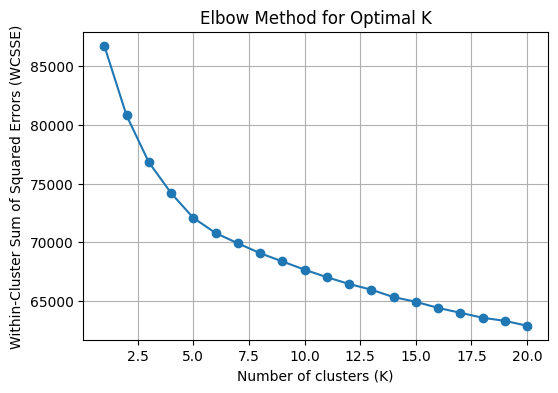

In [33]:
#Try k-means again using the tweet vectors instead of BoW
X_vectorized = np.vstack(extracted_features['tweet_vectors'].values)

# Use Elbow Method to investigate whether there are more clusters
# Compute WCSSE for different values of K
wcsse = []
K_range = range(1, 21)
# runs Kmeans for k = 1 to 20
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_vectorized)
    wcsse.append(kmeans.inertia_)
    print(f"WCSSE (Inertia) for K={k}:", kmeans.inertia_)


# 3. Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcsse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Errors (WCSSE)')
plt.grid(True)
plt.show()

WCSSE (Inertia) for K=1: 207457.40793536368
WCSSE (Inertia) for K=2: 172877.14965579426
WCSSE (Inertia) for K=3: 155995.17801644444
WCSSE (Inertia) for K=4: 143525.39651794295
WCSSE (Inertia) for K=5: 137164.6877367221
WCSSE (Inertia) for K=6: 131267.72532608264
WCSSE (Inertia) for K=7: 126234.9392219019
WCSSE (Inertia) for K=8: 121355.73908028894
WCSSE (Inertia) for K=9: 117612.98362645309
WCSSE (Inertia) for K=10: 115287.83750253187
WCSSE (Inertia) for K=11: 112722.45953468743
WCSSE (Inertia) for K=12: 110834.88099681726
WCSSE (Inertia) for K=13: 109082.18828837393
WCSSE (Inertia) for K=14: 106990.80428032577
WCSSE (Inertia) for K=15: 106026.44372449418
WCSSE (Inertia) for K=16: 104193.70856278029
WCSSE (Inertia) for K=17: 102531.2887508492
WCSSE (Inertia) for K=18: 101108.42332817003
WCSSE (Inertia) for K=19: 100626.18812305506
WCSSE (Inertia) for K=20: 98870.43895143375


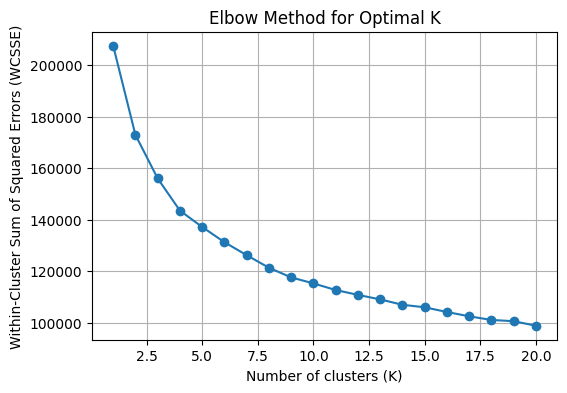

In [39]:
#Try k-means again using vader words

X_vectorized = np.vstack(extracted_features['VADER_vectors'].values)

# Use Elbow Method to investigate whether there are more clusters
# Compute WCSSE for different values of K
wcsse = []
K_range = range(1, 21)
# runs Kmeans for k = 1 to 20
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_vectorized)
    wcsse.append(kmeans.inertia_)
    print(f"WCSSE (Inertia) for K={k}:", kmeans.inertia_)


# 3. Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcsse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Errors (WCSSE)')
plt.grid(True)
plt.show()

WCSSE (Inertia) for K=1: 3992.5095040139513
WCSSE (Inertia) for K=2: 1552.898463046625
WCSSE (Inertia) for K=3: 824.2258805068411
WCSSE (Inertia) for K=4: 605.4767677018236
WCSSE (Inertia) for K=5: 463.654168355617
WCSSE (Inertia) for K=6: 382.6710186809794
WCSSE (Inertia) for K=7: 327.76468002469403
WCSSE (Inertia) for K=8: 291.5929041561532
WCSSE (Inertia) for K=9: 261.4648062119311
WCSSE (Inertia) for K=10: 234.0091882476962
WCSSE (Inertia) for K=11: 209.6946822473429
WCSSE (Inertia) for K=12: 195.4733305832801
WCSSE (Inertia) for K=13: 182.34893073741318
WCSSE (Inertia) for K=14: 169.18740915986905
WCSSE (Inertia) for K=15: 158.116915198261
WCSSE (Inertia) for K=16: 148.82462675421513
WCSSE (Inertia) for K=17: 140.60183158112477
WCSSE (Inertia) for K=18: 135.0420663067042
WCSSE (Inertia) for K=19: 128.9741524995299
WCSSE (Inertia) for K=20: 122.9341363980829


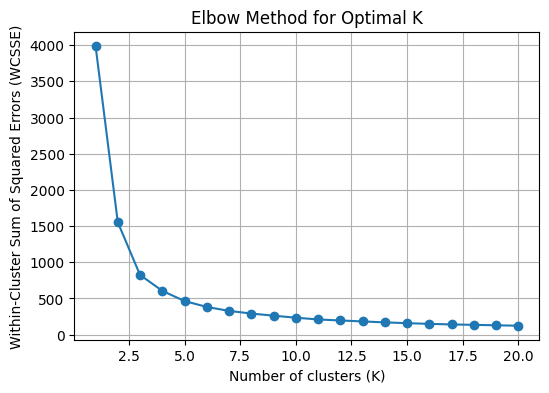

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.000,1.000,0.000,0.0000
2,0.000,1.000,0.000,0.0000
3,0.246,0.754,0.000,-0.5984
4,0.321,0.679,0.000,-0.5829
...,...,...,...,...
14634,0.000,0.783,0.217,0.3612
14635,0.286,0.714,0.000,-0.7906
14636,0.000,0.723,0.277,0.3182
14637,0.000,0.866,0.134,0.5027


In [ ]:
#Try k-means with the VADER sentiments

# Use Elbow Method to investigate whether there are more clusters
# Compute WCSSE for different values of K
wcsse = []
K_range = range(1, 21)
# runs Kmeans for k = 1 to 20
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(VADER_sentiments)
    wcsse.append(kmeans.inertia_)
    print(f"WCSSE (Inertia) for K={k}:", kmeans.inertia_)


# 3. Plot Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcsse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squared Errors (WCSSE)')
plt.grid(True)
plt.show()

WCSSE (Inertia): 9199.610597584207


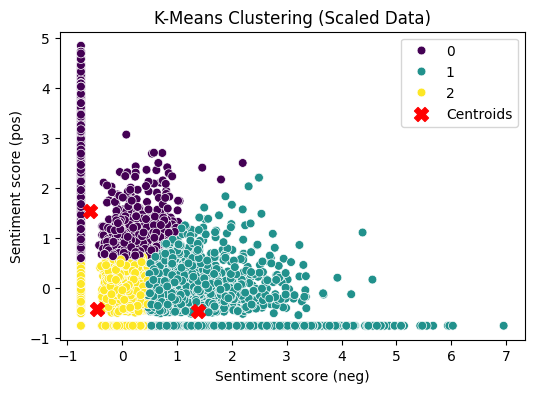

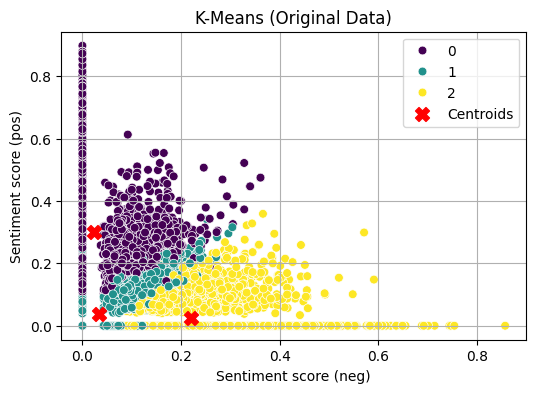

In [83]:
import seaborn as sns 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # create a StandardScaler object
df_original_plot = pd.DataFrame(VADER_sentiments, columns=["neg", "neu", "pos", "compound"])
VADER_scaled = scaler.fit_transform(df_original_plot[["neg", "pos"]])  # fit and transform the data


k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
kmeans.fit(VADER_scaled)
# Cluster labels assigned to each data point (0, 1, or 2 for 3 clusters)
labels = kmeans.labels_

print("WCSSE (Inertia):", kmeans.inertia_)

# Create DataFrame for plotting
# choose only the "neg" and "pos" columns for 2D visualization, we assume they are the most important features
df_plot = pd.DataFrame(VADER_scaled, columns=["neg", "pos"])
df_plot['Cluster'] = labels

plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_plot,
                x="neg",
                y="pos",
                hue='Cluster',
                palette='viridis',
                s=40)

# Plot centroids
centroids = kmeans.cluster_centers_
# neg and pos are at index 0 and 1
plt.scatter(centroids[:, 0], centroids[:, 1],
            s=100, c='red', marker='X', label='Centroids')

plt.title("K-Means Clustering (Scaled Data)")
plt.xlabel("Sentiment score (neg)")
plt.ylabel("Sentiment score (pos)")
plt.legend()
plt.show()

#Plot without scaling for comparison
kmeans_original = KMeans(n_clusters=k, n_init=10, random_state=0)
kmeans_original.fit(VADER_sentiments)
labels = kmeans_original.labels_
df_original_plot['Cluster'] = labels
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_original_plot,
                x="neg",
                y="pos",
                hue='Cluster',
                palette='viridis',
                s=40)

centroids_original = kmeans_original.cluster_centers_
# neg and pos are at index 0 and 2
plt.scatter(centroids_original[:, 0], centroids_original[:, 2],
            s=100, c='red', marker='X', label='Centroids')
plt.title("K-Means (Original Data)")
plt.xlabel("Sentiment score (neg)")
plt.ylabel("Sentiment score (pos)")
plt.legend()
plt.grid(True)
plt.show()

Weakness of k-means clustering: sensitive to outliers, which might be the case here. We try using DBSCAN (Density-Based Spatial Clustering of Applications with Noise), which finds arbitary shaped points and clusters.

DBSCAN does not require K clusters initially. Instead, it requires two parameters: eps and minPts.

eps: it is the radius of specific neighborhoods. If the distance between two points is less than or equal to esp, it will be considered its neighbors.
minPts: minimum number of data points in a given neighborhood to form the clusters. 
DBSCAN uses these two parameters to define a core point, border point, or outlier.

https://www.kdnuggets.com/2022/08/implementing-dbscan-python.html


Now, we clearly know two important parameters, eps and minPts. So our next jobs is trying to find the best for eps and minPtes.

The core points of DBSCAN are defined as follows:
Core point: ∣Nε​(p)∣ ≥ minPts 
Nε​(p)={q∣distance(p,q) ≤ ε}）

First need to determine what density scale (minPts)  consider to be “dense”;
then determine how large a radius (eps) is required for each point’s neighborhood to contain that many samples.

According to the Density Reachability and Curse of Dimensionality, there are two ways to estimate the value of minPts

1、min_samples = number of dimensions + 1
Underlying Meaning：
Minimum reasonable threshold: ensures that in a d-dimensional space you have enough neighbors to define a small local hyper-volume (i.e., an easy/lenient density definition, more points qualify as core).
When to use:
• When the dataset is small (hundreds or a few thousand samples)
• When noise is low and clusters are well separated
• When you prefer easier cluster formation and don’t mind fewer noise points

2、min_samples ≈ 2 × number of dimensions
Underlying Meaning：
More conservative density threshold: requires denser neighborhoods to qualify as core points, yielding more robust clusters at the cost of labeling more points as noise.
When to use:
• Higher-dimensional data or complex structure • Larger datasets (e.g., 10k+) • Noticeable noise/outliers • You prefer stability/robustness even if more points become noise
（⚠️⚠️⚠️ If the Dimension are two high, like 300D,  the formula seems to be ineffective, 
we usually try to find a best value in specific section）

(14639, 300)


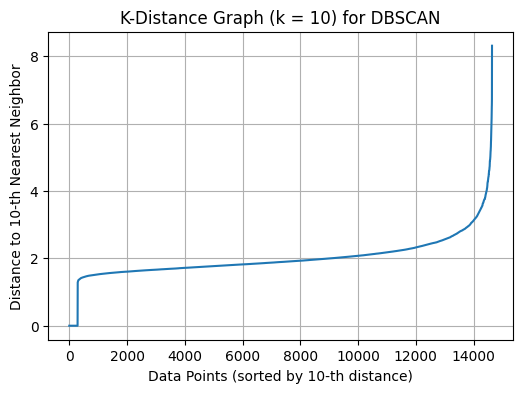

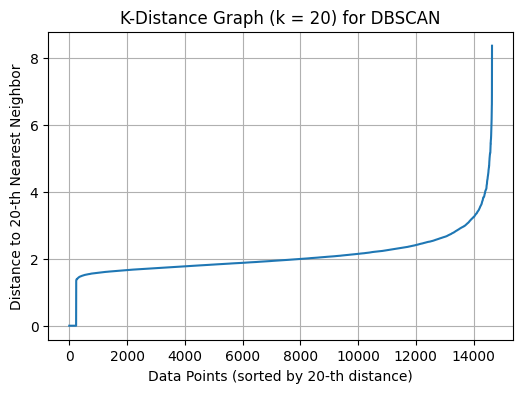

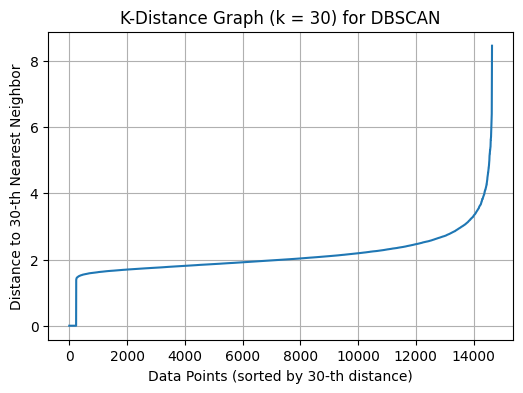

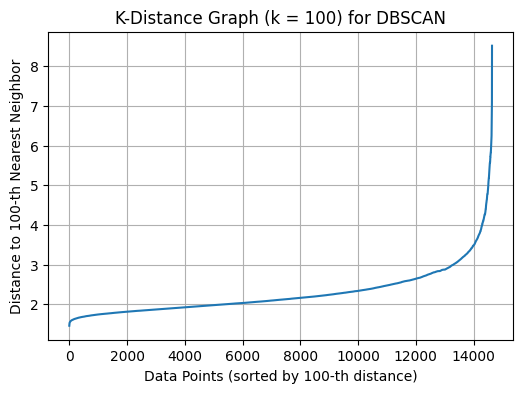

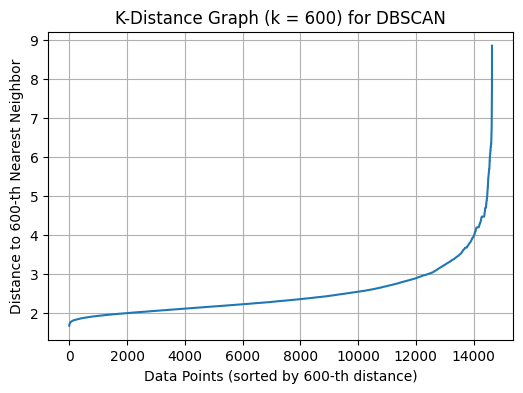

In [37]:
#An important parameter for DBSCAN is the epsilon（ε） neighbourhood distance
#To estimate a good value for epsilon, we can plot the k-distance graph
#
#And look for the "elbow" point in the graph

#X_vader

from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

# 300D is too high-dimensional for NearestNeighbors to work properly
print(X_vectorized.shape)


k_values = [10, 20, 30, 100, 600]
for k in k_values:
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X_vectorized)
#For each sample point 𝑥𝑖, Find the k nearest points (close neighbors) to it 
# (distances are sorted from min to max)
    distances, indices = neighbors_fit.kneighbors(X_vectorized)

    #distances = np.sort(distances, axis=0)
    distances = np.sort(distances[:,k-1])
    plt.figure(figsize=(6,4))
    plt.plot(distances)
    plt.title(f"K-Distance Graph (k = {k}) for DBSCAN")
    plt.xlabel(f"Data Points (sorted by {k}-th distance)")
    plt.ylabel(f"Distance to {k}-th Nearest Neighbor")  
    plt.grid(True)
    plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN with chosen eps and minPts
dbscan = DBSCAN(eps=10000, min_samples=3) # Adjust eps and min_samples as needed

# Fit the model to the data and get cluster labels
clusters = dbscan.fit_predict(X_vectorized)

print(clusters.max())

0


Check accuracy of clustering against dataset "airline_sentiment" column

In [28]:
#Check accuracy of clustering against dataset "airline_sentiment" column
#Check that the accuracy correlates against the "confidence" column,
# ie. the misrepresented tweets are those that have low confidence scores
# and those that are correct should have high confidence

(14639, 4)


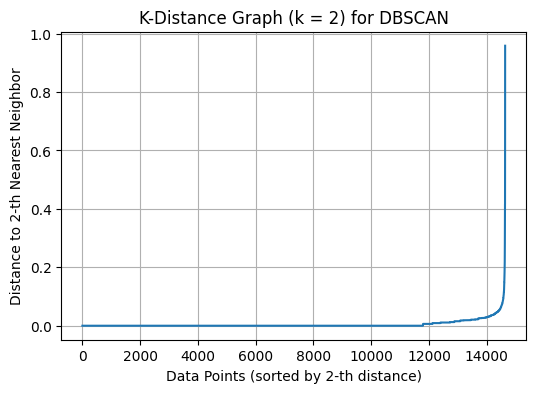

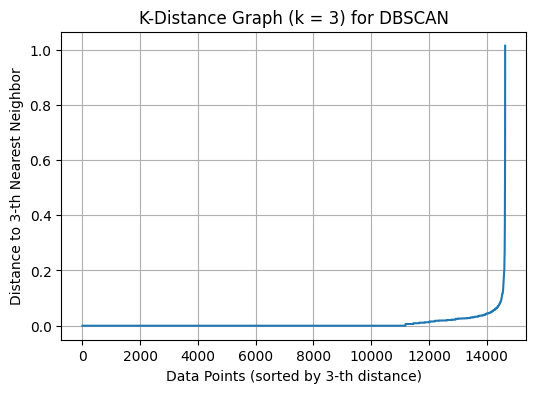

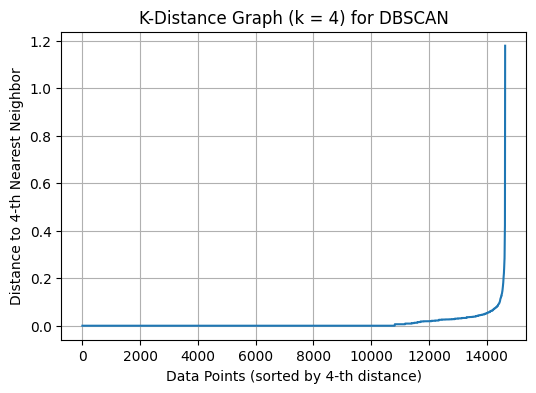

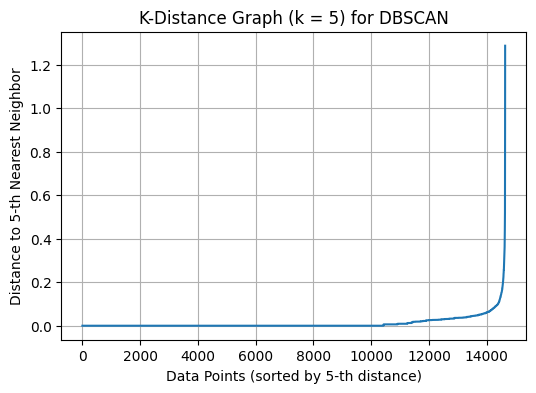

In [96]:
# Compared to the k-means clustering, different data samples have different eps and min_samples
# So we need to recalulate the k-distance graph using VADER_sentiments

#X_vader

from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt


print(VADER_sentiments.shape)
df_vader = pd.DataFrame(VADER_sentiments, columns=["neg", "neu", "pos", "compound"])
X_vader = df_vader[["neg", "pos"]].values

scaler = StandardScaler()
X_vader_scaled = scaler.fit_transform(X_vader)

k_values = [2, 3, 4, 5]
for k in k_values:
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X_vader_scaled)
#For each sample point 𝑥𝑖, Find the k nearest points (close neighbors) to it 
# (distances are sorted from min to max)
    distances, indices = neighbors_fit.kneighbors(X_vader_scaled)

    #distances = np.sort(distances, axis=0)
    distances = np.sort(distances[:,k-1])
    plt.figure(figsize=(6,4))
    plt.plot(distances)
    plt.title(f"K-Distance Graph (k = {k}) for DBSCAN")
    plt.xlabel(f"Data Points (sorted by {k}-th distance)")
    plt.ylabel(f"Distance to {k}-th Nearest Neighbor")  
    plt.grid(True)
    plt.show()


Original shape: (14639, 2)
After scaling: (14639, 2)
Mean: [-0.  0.] Std: [1. 1.]
{np.int64(-1): np.int64(166), np.int64(0): np.int64(3222), np.int64(1): np.int64(3728), np.int64(2): np.int64(2903), np.int64(3): np.int64(4492), np.int64(4): np.int64(26), np.int64(5): np.int64(13), np.int64(6): np.int64(13), np.int64(7): np.int64(12), np.int64(8): np.int64(14), np.int64(9): np.int64(16), np.int64(10): np.int64(8), np.int64(11): np.int64(5), np.int64(12): np.int64(9), np.int64(13): np.int64(7), np.int64(14): np.int64(5)}
Estimated number of noise points: 166
Clusters found: 15
Noise ratio: 0.011


/var/folders/dh/3b02pl5j0_55lqkbtyc4ssj00000gn/T/ipykernel_43672/413806683.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(unique_clusters))


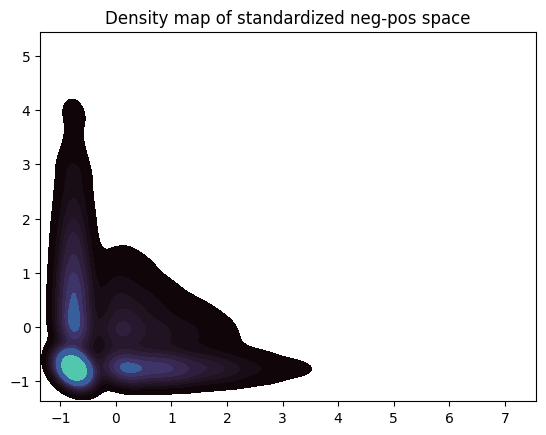

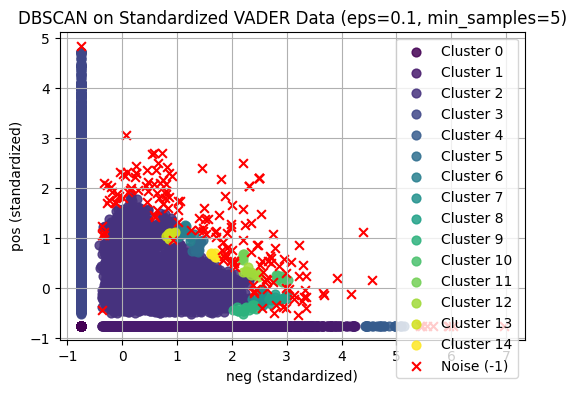

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from matplotlib import cm

# Based on the k-distance graph, set eps and min_samples
eps = 0.1          
min_samples = 5     


df = pd.DataFrame(VADER_sentiments, columns=["neg", "pos"])
X = df[["neg", "pos"]].values

print("Original shape:", X.shape)

scaler = StandardScaler()
Xs = scaler.fit_transform(X)   
print("After scaling:", Xs.shape)
print("Mean:", Xs.mean(axis=0).round(3), "Std:", Xs.std(axis=0).round(3))


db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(Xs)   

unique, counts = np.unique(labels, return_counts=True)
# check the distribution of cluster labels
print(dict(zip(unique, counts)))

sns.kdeplot(x=Xs[:, 0], y=Xs[:, 1], fill=True, cmap="mako")
plt.title("Density map of standardized neg-pos space")

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_ratio = (labels == -1).mean()
n_noise_ = list(labels).count(-1)

print("Estimated number of noise points: %d" % n_noise_)
print(f"Clusters found: {n_clusters}")
print(f"Noise ratio: {noise_ratio:.3f}")

unique_clusters = sorted(c for c in set(labels) if c != -1)
colors = cm.get_cmap('viridis', len(unique_clusters))

plt.figure(figsize=(6, 4))


for i, c in enumerate(unique_clusters):
    mask = (labels == c)
    plt.scatter(Xs[mask, 0], Xs[mask, 1],
                s=40, alpha=0.85,
                color=colors(i), label=f"Cluster {c}")


mask_noise = (labels == -1)
if mask_noise.any():
    plt.scatter(Xs[mask_noise, 0], Xs[mask_noise, 1],
                s=40, c='red', marker='x', label='Noise (-1)')

plt.title(f"DBSCAN on Standardized VADER Data (eps={eps}, min_samples={min_samples})")
plt.xlabel("neg (standardized)")
plt.ylabel("pos (standardized)")
plt.legend()
plt.grid(True)
plt.show()


## Step 5: Something special

From the literature review, we discovered that it's possible for a single tweet to have both positive and negative sentiments when describing different things. Hence, we investigate to what extent this might be true in the dataset, and whether that could have caused some of the misclassified samples.